# **Clustering Debit internet**

Nous allons procèder ici à un clustering pour pouvoir discrétiser en une colonne les colonnes suivantes : 
- *`AccWeb_rtc`* 
- *`AccWeb_cablefibreoptique`* 
- *`AccWeb_adsl`* 
- *`AccWeb_autreshautdebit`* 
- *`AccWeb_nesaitpas`*
- *`AccWeb_aucun`*
- *`DebitWeb`*

Nous nous permettons de discrétiser ces colonnes car elles sont toutes liées, elles concernent l'accés au WEB. Comme ce sont des questions, on préférerait avoir une seule colonne qui donne le niveau d'accés Web, par exemple "Très bon" ou "Mauvais".
Pour faire cela, nous allons recourir un algorithme de classification non supervisée qui est **KMeans** qui va permettre de rassembler les établissements qui se ressemblent le plus et dégager des groupes sans connaître à l'avance les classes souhaitées.

### *Import des bibliothèques*

In [1]:
import pandas as pd
import prince as pc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly_express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler

# import image module
from IPython.display import Image
import kaleido
import io
from PIL import Image as ImagePIL

### *Import des données et leur traitement*

In [2]:
df = pd.read_csv('../data/lycee-college/fr-en-etic_2d.csv', sep=';')


#on garde les données les plus récentes, donc 2019
df = df.loc[df["Millesime"] == 2019]

#On consulte les colonnes existantes
df.columns

Index(['Code_UAI', 'Millesime', 'Code_nature', 'nature_uai', 'typ_etab',
       'Academie', 'Departement', 'NbEleve', 'NbEnseignant',
       'SiEtabCentreRessource', 'SiProjetNumEcole', 'SiEntDisponible',
       'SiProjEtabIntegreENT', 'Maint_PersCollect', 'Maint_PrestaExt',
       'Maint_PersonnelEducNatHsEtab', 'Maint_PersonnelEtab',
       'Maint_AutreNeSaitPas', 'Maint_Personne', 'NbRessourceEdit',
       'TpRess_ManuelNum', 'TpRess_AnimScienLogiSimu', 'TpRess_Bdd',
       'TpRess_LogiOutils', 'TpRess_OuvRef', 'TpRess_ResEntrainement',
       'TpRess_Autres', 'TpRess_aucune', 'ServInt_NoteElev', 'ServInt_AbsElev',
       'ServInt_EdtElevCls', 'ServInt_CahierTxt', 'ServInt_DocRessPeda',
       'ServInt_AgdActuEtab', 'ServInt_PlatApp', 'ServInt_Autres',
       'ServInt_aucun', 'NbTerminaux', 'NbTablette', 'NbTablettePC',
       'NbMicroMoins5', 'NbMicroPortable', 'NbPortAffEl', 'NbPortAffEns',
       'NbEleveEqASH', 'NbPosteEqASH', 'NbTBI', 'propClassesAvecTBI',
       'NbVideoProj',

On supprime toutes les colonnes qui n'ont rien à voir avec notre analyse. On va d'abord fixer l'index à l'UAI pour pouvoir ensuite joindre le résultat aux autres données qui va nous servir. On va également supprimer les lignes qui contiennent des *"NaN"* (Not a Number)

In [3]:
df_web = df.copy()
df_web.set_index('Code_UAI', inplace=True)

#Suppression des colonnes inutiles
df_web.drop(columns=['Millesime', 'Code_nature', 'nature_uai', 'typ_etab',
       'Academie', 'Departement', 'NbEleve', 'NbEnseignant',
       'SiEtabCentreRessource', 'SiProjetNumEcole', 'SiEntDisponible',
       'SiProjEtabIntegreENT', 'Maint_PersCollect', 'Maint_PrestaExt',
       'Maint_PersonnelEducNatHsEtab', 'Maint_PersonnelEtab',
       'Maint_AutreNeSaitPas', 'Maint_Personne', 'NbRessourceEdit',
       'TpRess_ManuelNum', 'TpRess_AnimScienLogiSimu', 'TpRess_Bdd',
       'TpRess_LogiOutils', 'TpRess_OuvRef', 'TpRess_ResEntrainement',
       'TpRess_Autres', 'TpRess_aucune', 'ServInt_NoteElev', 'ServInt_AbsElev',
       'ServInt_EdtElevCls', 'ServInt_CahierTxt', 'ServInt_DocRessPeda',
       'ServInt_AgdActuEtab', 'ServInt_PlatApp', 'ServInt_Autres',
       'ServInt_aucun', 'NbTerminaux', 'NbTablette', 'NbTablettePC',
       'NbMicroMoins5', 'NbMicroPortable', 'NbPortAffEl', 'NbPortAffEns',
       'NbEleveEqASH', 'NbPosteEqASH', 'NbTBI', 'propClassesAvecTBI',
       'NbVideoProj', 'NbClassMobile', 'NbLecteurMpx', 'NbImpr3D',
       'SiWifi', 'SalleInternet', 'PostesInfoElvHorsCours',
       'SiPareFeuEtab', 'SiOuifiltrageWeb', 'ControlePosteriori',
       'SiCharteUsageWeb', 'Diffch_AnnexeeRI',
       'Diffch_DossierRentreeEnseignants', 'Diffch_CRConseilAdmin',
       'Diffch_DiffusionParents', 'Diffch_Autres', 'AccesParentCharte',
       'ElvAuthentif', 'SiVisioConferenc', 'SiEntUtilise',
       'TypeMatHandi_Tablette', 'TypeMatHandi_OrdiPort', 'TypeMatHandi_LogApp',
       'TypeMatHandi_Autre', 'Code_region', 'Libelle_region'], inplace=True)


df_web.dropna(inplace=True, axis=0)

Ensuite, on renomme les colonnes pour pouvoir les manipuler plus facilement et aussi pour que les colonnes soient plus lisible

In [4]:
old_columns = df_web.columns

for column in old_columns:
    df_web.rename(columns={column: column.replace('AccWeb_', '').lower()}, inplace=True)

df_web.columns

Index(['rtc', 'cablefibreoptique', 'adsl', 'autreshautdebit', 'nesaitpas',
       'aucun', 'debitweb'],
      dtype='object')

On vérifie que les modifications que nous avons appliquées ont bien été effectuées

In [5]:
df_web.info()
df_web.head()

<class 'pandas.core.frame.DataFrame'>
Index: 432 entries, 0810016C to 0820917B
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rtc                432 non-null    object
 1   cablefibreoptique  432 non-null    object
 2   adsl               432 non-null    object
 3   autreshautdebit    432 non-null    object
 4   nesaitpas          432 non-null    object
 5   aucun              432 non-null    object
 6   debitweb           432 non-null    object
dtypes: object(7)
memory usage: 27.0+ KB


,rtc,cablefibreoptique,adsl,autreshautdebit,nesaitpas,aucun,debitweb
Code_UAI,,,,,,,
0810016C,non,oui,non,non,non,non,De2a10
0810026N,non,oui,non,non,non,non,10moins50
0810041E,non,oui,non,non,non,non,De2a10
0810124V,non,oui,oui,non,non,non,10moins50
0810125W,non,oui,non,non,non,non,100OuPlus


Maintenant, il est important de transformer les modalités "String" qu'on a en float, car l'algorithme de **KMeans** marche avec des floats, nous décidons d'affecter la valeur de 1 pour les valeurs "oui" et 0 pour les valeurs "non". Pour la colonne de Debit Web, elle contient des données selon niveau. Nous allons voir combien de modalités elle contient pour pouvoir accorder un float à chaque modalité

In [6]:
df_web.debitweb.value_counts()

De2a10        185
10moins50     185
InfA2          26
50Moins100     19
100OuPlus      17
Name: debitweb, dtype: int64

In [7]:
#Formatter des colonnes
columns_names = df_web.columns

for column in columns_names:
    if(column == "debitweb"):
        df_web[column] = df_web[column].replace({'InfA2': 0, 'De2a10': 1, '10moins50': 2, '50Moins100': 3, '100OuPlus': 4})
        df_web[column] = df_web[column].astype('float64')
    else:
        df_web[column] = df_web[column].replace({'oui': 1, 'non': 0})
        df_web[column] = df_web[column].astype('float64')

df_web.head(3)

,rtc,cablefibreoptique,adsl,autreshautdebit,nesaitpas,aucun,debitweb
Code_UAI,,,,,,,
0810016C,0.0,1.0,0.0,0.0,0.0,0.0,1.0
0810026N,0.0,1.0,0.0,0.0,0.0,0.0,2.0
0810041E,0.0,1.0,0.0,0.0,0.0,0.0,1.0


### Corrélation

On va vérifier la corrélation entre les diffèrentes variables

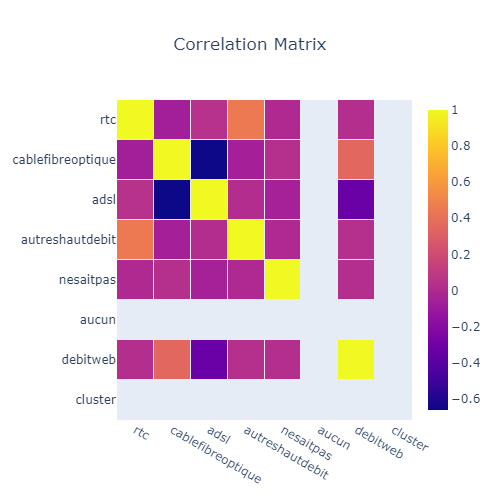

In [20]:
columns_names = df_web.columns

heat = go.Heatmap(
    z = df_web.corr(),
    x = columns_names,
    y = columns_names,
    xgap = 1, ygap = 1,
    colorbar_thickness=20,
    colorbar_ticklen=3,
    hovertext = df_web.corr(),
    hoverinfo='text'
)

layout = go.Layout(
    title_text= "Correlation Matrix",
    title_x = 0.5,
    width=600, height=600,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange='reversed'
)

fig = go.Figure(data=[heat], layout=layout)
Image(fig.to_image(format="png", width=500, height=500, scale=1))
#fig.show()

On remarque qu'il y a une corrélation positive entre la fibre optique et le débit Web, ce qui est logique. Il existe également une corrélation négative entre l'ADSL et le débit web, si l'établissement a l'ADSL, alors le débit diminue. 

---------------------------------------------

### Clustering : KMeans

On peut maintenant utiliser l'algorithme pour créer plusieurs classes. Nous avons d'abord essayé de donner en paramètres pour le nombre de clusters 5, nous avons vu qu'il y avait des classes qui ont des centres qui partagent les mêmes valeurs pour les 6 colonnes ci-dessous. Nous avons donc décidé de créer seulement deux classes, car ce qui change entre les classes sont seulement les valeurs des deux colonnes "ADSL" ou "fibre optique". Cela influence directement le débit, ce qui est logique. Quand on a la fibre optique, le débit Web est supérieur que l'ADSL. Nous avons donc décidé de créer seulement deux classes et donc deux modalités pour la colonne Acces Web :
- Bon
- Moyen

Voyons le résultat de notre clustering :

In [9]:
km_web = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300,
    random_state=0
)

y_km_web = km_web.fit_predict(df_web)

resultat = pd.DataFrame(km_web.cluster_centers_, columns=[km_web.feature_names_in_])

resultat

,rtc,cablefibreoptique,adsl,autreshautdebit,nesaitpas,aucun,debitweb
0,4.524887e-03,0.828054,0.384615,0.018100,4.524887e-03,0.0,2.239819
1,-3.903128e-18,0.497630,0.672986,0.004739,-3.903128e-18,0.0,0.876777


> Nous avons affiché au dessus les valeurs des centres des deux classes pour chaque colonne, les moyennes de la classe. 
> Pour que cela soit plus clair, nous considérons que quand nous avons une valeur supérieur à 0.5 c'est que cela vaut "oui". Dans le cas contraire, cela vaudrait "non". Pour ce qui est de la colonne débit, nous prenons l'entier le plus proche qui va nous donner la modalité.

In [10]:
columns_names = km_web.feature_names_in_


def change_float_to_int(row):
    for rowt in row:
        if(rowt > 0.51):
            return 1
        else:  
            return 0


def change_float_to_int_deb(row):
    for rowt in row:
        if(rowt < 0.5):
            return 0
        elif(rowt < 1.5):
            return 1
        elif(rowt < 2.5):
            return 2
        elif(rowt < 3.5):
            return 3
        else:
            return 4


for column in km_web.feature_names_in_:
    if(column == "debitweb"):
        resultat[column] = resultat[column].apply(lambda row : change_float_to_int_deb(row), axis='columns')
    else:
        resultat[column] = resultat[column].apply(lambda row : change_float_to_int(row), axis='columns')


resultat


,rtc,cablefibreoptique,adsl,autreshautdebit,nesaitpas,aucun,debitweb
0,0,1,0,0,0,0,2
1,0,0,1,0,0,0,1


In [11]:
for column in km_web.feature_names_in_:
    if(column == "debitweb"):
        resultat[column] = resultat[column].replace({0: 'InfA2', 1: 'De2a10', 2: '10moins50', 3: '50Moins100', 4: '100OuPlus'})
        resultat[column] = resultat[column].astype('str')
    else:
        resultat[column] = resultat[column].replace({0: 'non', 1: 'oui'})
        resultat[column] = resultat[column].astype('str')


resultat

,rtc,cablefibreoptique,adsl,autreshautdebit,nesaitpas,aucun,debitweb
0,non,oui,non,non,non,non,10moins50
1,non,non,oui,non,non,non,De2a10


On voit donc bien quelles sont les caractéristiques d'une classe, on va donc accorder la modalité "Bon" pour la première classe qui a la fibre optique et un débit plus important. On va accorder la modalité "Moyen" pour la deuxième classe car ils ont seulement l'ADSL et un débit Web plus petit.

On va maintenant affecter à chaque établissement la cluster à laquelle il appartient.

In [12]:
df_web["cluster"] = y_km_web
df_web.head()


,rtc,cablefibreoptique,adsl,autreshautdebit,nesaitpas,aucun,debitweb,cluster
Code_UAI,,,,,,,,
0810016C,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
0810026N,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0
0810041E,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
0810124V,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0
0810125W,0.0,1.0,0.0,0.0,0.0,0.0,4.0,0


--------------------------------------------

Après cela, nous allons essayer de représenter ça graphiquement pour voir ce que cela donne pour voir si il y a eu une bonne découpe des clusters. Pour cela nous allons procéder à une ACP comme nous avons *`p`* variables quantitatives. Nous allons utiliser la librairie prince pour faire notre ACP.

In [13]:
pca_web = pc.PCA(
    n_components=2,
    random_state=0,
    n_iter=100,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    engine='auto',
    check_input=True
)

pca_web = pca_web.fit(df_web.drop("cluster", axis=1))

On va d'abord regarder l'inertie totale expliquée par l'ACP pour savoir à quel point elle est fiable.

In [14]:
print("Inertie totale expliquée :",pca_web.explained_inertia_, " soit ", pca_web.explained_inertia_.sum() * 100, "%")
print("Valeurs propres :",pca_web.eigenvalues_)
print("Inertie totale :",pca_web.total_inertia_)

Inertie totale expliquée : [0.32139286 0.24087976]  soit  56.22726223040249 %
Valeurs propres : [1.92835715 1.44527858]
Inertie totale : 5.999999999999998


On voit que nous avons 56,5 % de l'information qui est restitué. Ce n'est pas très haut, il aurait été préférable d'avoir plus de 66% mais nous n'avons pas d'autres choix. Il va falloir interprêter avec des pincettes.

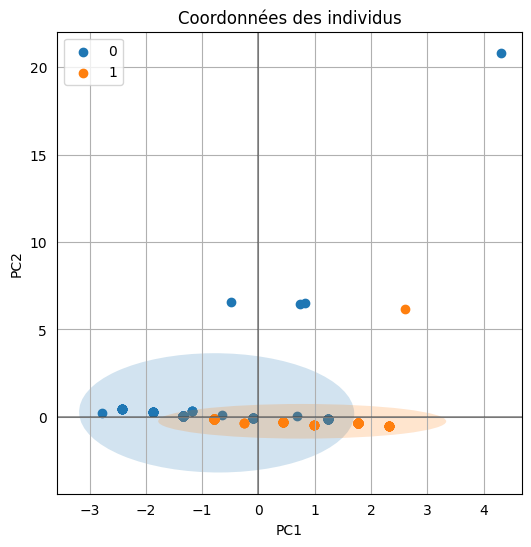

In [15]:
ax_web = pca_web.plot_row_coordinates(
    df_web.drop("cluster", axis=1),
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    labels=None,
    color_labels=df_web["cluster"],
    show_points=True
)
ax_web.set_xlabel("PC{}".format(1))
ax_web.set_ylabel("PC{}".format(2))
ax_web.set_title("Coordonnées des individus")
ax_web.legend()

----------------------

In [16]:
df_web.cluster = df_web.cluster.astype('str')
df_web.info()

<class 'pandas.core.frame.DataFrame'>
Index: 432 entries, 0810016C to 0820917B
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rtc                432 non-null    float64
 1   cablefibreoptique  432 non-null    float64
 2   adsl               432 non-null    float64
 3   autreshautdebit    432 non-null    float64
 4   nesaitpas          432 non-null    float64
 5   aucun              432 non-null    float64
 6   debitweb           432 non-null    float64
 7   cluster            432 non-null    object 
dtypes: float64(7), object(1)
memory usage: 30.4+ KB


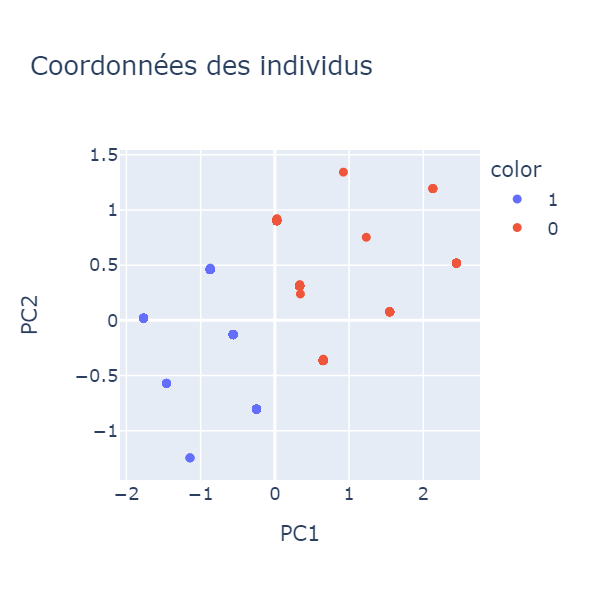

In [25]:
pca = PCA(n_components=2)
components = pca.fit_transform(df_web.drop("cluster", axis=1))

fig = px.scatter(components, x=0, y=1, color=df_web["cluster"], title="Coordonnées des individus", labels={"0": "PC1", "1": "PC2"})
Image(fig.to_image(format="png", width=400, height=400, scale=1.5))
#fig.show()

On voit bien ici que les classes sont bien divisées, le clustering a trés bien marché. On ne voit pas tous les points car il y a beaucoup de points qui sont superposées car ils partagent les mêmes coordonnées

### Création de la colonne `Accès Web`

Nous pouvons maintenant attribuer à chaque établissement une des deux valeurs prédéfinies précedemment. Nous passons de 6 colonnes à une seule.

In [18]:
df_web_final = pd.DataFrame(df_web.cluster.replace({"0" : "Bon", "1":"Moyen"}))
df_web_final.rename(columns={"cluster" : "acces_web"}, inplace=True)

df_web_final.head(3)

,acces_web
Code_UAI,
0810016C,Moyen
0810026N,Bon
0810041E,Moyen


### *Exportation des données dans un fichier csv*

Nous allons l'importer sous un format `csv` pour pouvoir faire des jointures avec les autres données

In [19]:
df_web_final.to_csv("../data/analyses/acces_web.csv", index=True, sep=";")